## Supervised PatchTST

![PatchTST Overview](./fig/PatchTST_overview.jpg)

![Transformer Backbone](./fig/Transformer_backbone.jpg)

In [1]:
# Import Libraries
import os
import math
import random
import argparse
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Ignore warnings, block CUDA kernel launches
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### 1. PatchTST Backbone

#### 1.1. Reinversible Instance Normalization

In [2]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

#### 1.2. Positional Encoding

In [3]:
def positional_encoding(patch_num, d_model):
    W_pos = torch.empty((patch_num, d_model))
    nn.init.uniform_(W_pos, -0.02, 0.02)
    return nn.Parameter(W_pos, requires_grad=True)

#### 1.3. Encoder Block

In [4]:
class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, n_heads, attn_dropout=0.0):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        head_dim = d_model // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=False)

    def forward(self, q, k, v):
        attn_scores = torch.matmul(q, k) * self.scale       # shape : [bs x n_heads x max_q_len x max_q_len]
        
        # normalize the attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)       # shape : [bs x n_heads x max_q_len x max_q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)              # shape : [bs x n_heads x max_q_len x d_v]
        
        return output, attn_weights, attn_scores


class MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        d_k = d_model // n_heads
        d_v = d_model // n_heads

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=True)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=True)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=True)

        # Scaled Dot-Product Attention (multiple heads)
        self.sdp_attn = ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout)

        # Poject output
        self.to_out = nn.Sequential(nn.Linear(n_heads * d_v, d_model), nn.Dropout(proj_dropout))

    def forward(self, Q):
        bs = Q.size(0)
        K = Q
        V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs,-1,self.n_heads,self.d_k).transpose(1,2)   # [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs,-1,self.n_heads,self.d_k).permute(0,2,3,1) # [bs x n_heads x d_k x max_q_len]
        v_s = self.W_V(V).view(bs,-1,self.n_heads,self.d_v).transpose(1,2)   # [bs x n_heads x max_q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s)

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v)
        # output: [bs x q_len x n_heads * d_v]
        
        output = self.to_out(output)
        
        return output, attn_weights, attn_scores


class TSTEncoderLayer(nn.Module):
    def __init__(self, patch_num, d_model, n_heads, d_ff=256, attn_dropout=0.0, dropout=0.0):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads
        d_v = d_model // n_heads

        # Multi-Head attention
        self.self_attn = MultiheadAttention(d_model, n_heads, attn_dropout=attn_dropout, proj_dropout=dropout)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        
        self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=True),
                                nn.GELU(),
                                nn.Dropout(dropout),
                                nn.Linear(d_ff, d_model, bias=True))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)

        self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))

    def forward(self, src):
        # Multi-Head attention sublayer
        ## Multi-Head attention
        src2, attn, scores = self.self_attn(src)
        
        ## Add & Norm
        src = src + self.dropout_attn(src2)
        src = self.norm_attn(src)

        # Feed-forward sublayer
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2)
        src = self.norm_ffn(src)

        return src, scores


class TSTEncoder(nn.Module):
    def __init__(self, patch_num, d_model, n_heads, d_ff=None, attn_dropout=0.0, dropout=0.0, n_layers=1):
        super().__init__()
        self.layers = nn.ModuleList([TSTEncoderLayer(patch_num, d_model, n_heads=n_heads, d_ff=d_ff, 
                                                     attn_dropout=attn_dropout, dropout=dropout) 
                                                     for i in range(n_layers)])

    def forward(self, src):
        output = src
    
        for mod in self.layers:
            output, scores = mod(output)
        return output


class TSTiEncoder(nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, 
                 n_layers=3, d_model=128, n_heads=16, 
                 d_ff=256, attn_dropout=0.0, dropout=0.0, **kwargs):     
        super().__init__()
        
        # Input encoding
        self.W_P = nn.Linear(patch_len, d_model)

        # Positional encoding
        self.W_pos = positional_encoding(patch_num, d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(patch_num, d_model, n_heads, d_ff=d_ff, 
                                  attn_dropout=attn_dropout, dropout=dropout, n_layers=n_layers)
        
    def forward(self, x):               # x: [bs x c_in x patch_len x patch_num]
        c_in = x.shape[1]
        
        # Input encoding
        x = x.permute(0,1,3,2)          # x: [bs x c_in x patch_num x patch_len]
        x = self.W_P(x)                 # x: [bs x c_in x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3])) # u: [bs * c_in x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                    # u: [bs * c_in x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                             # z: [bs * c_in x patch_num x d_model]
        z = torch.reshape(z, (-1,c_in,z.shape[-2],z.shape[-1]))         # z: [bs x c_in x patch_num x d_model]
        z = z.permute(0,1,3,2)                                          # z: [bs x c_in x d_model x patch_num]
        
        return z 

#### 1.4. Flatten Head

In [5]:
class Flatten_Head(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0.0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)
            
    def forward(self, x):       # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)     # x: [bs x nvars x nf]
        x = self.linear(x)      # x: [bs x nvars x target_window]
        x = self.dropout(x)
        return x

#### 1.5. Backbone

In [6]:
class PatchTST_backbone(nn.Module):
    def __init__(self, c_in, context_window, target_window, patch_len, stride, 
                 n_layers=3, d_model=128, n_heads=16, d_ff=256, 
                 attn_dropout=0.0, dropout=0.0, head_dropout=0.0,  
                 revin=True, affine=True, subtract_last=False, **kwargs):    
        super().__init__()
        
        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)
        
        # Patching
        self.patch_len = patch_len
        self.stride = stride
        patch_num = int((context_window - patch_len)/stride + 1)
        self.padding_patch_layer = nn.ReplicationPad1d((0, stride)) 
        patch_num += 1
        
        # Backbone 
        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, 
                                    n_layers=n_layers, d_model=d_model, n_heads=n_heads,
                                    d_ff=d_ff, attn_dropout=attn_dropout, dropout=dropout, 
                                    **kwargs)

        # Head
        self.head_nf = d_model * patch_num
        self.n_vars = c_in

        self.head = Flatten_Head(self.n_vars, self.head_nf, 
                                 target_window, head_dropout=head_dropout)
        
    
    def forward(self, z):
        # norm
        if self.revin: 
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)
            
        # do patching
        z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)  
        z = z.permute(0,1,3,2)
        
        # model
        z = self.backbone(z)                                               
        z = self.head(z)                                                   
        
        # denorm
        if self.revin: 
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'denorm')
            z = z.permute(0,2,1)
        return z

### 2. PatchTST Model

In [7]:
class PatchTST(nn.Module):
    def __init__(self, configs, **kwargs):
        
        super().__init__()
        
        # load parameters
        c_in = configs.enc_in
        context_window = configs.seq_len
        target_window = configs.pred_len
        patch_len = configs.patch_len
        stride = configs.stride
        n_layers = configs.e_layers
        d_model = configs.d_model
        n_heads = configs.n_heads
        d_ff = configs.d_ff
        dropout = configs.dropout
        attn_dropout = configs.attn_dropout
        head_dropout = configs.head_dropout
        revin = configs.revin
        affine = configs.affine
        subtract_last = configs.subtract_last        
        
        # model
        self.model = PatchTST_backbone( c_in = c_in, 
                                        context_window = context_window, 
                                        target_window = target_window, 
                                        patch_len = patch_len, 
                                        stride = stride, 
                                        n_layers = n_layers, 
                                        d_model = d_model,
                                        n_heads = n_heads, 
                                        d_ff = d_ff,
                                        dropout = dropout, 
                                        attn_dropout = attn_dropout,
                                        head_dropout = head_dropout,
                                        revin = revin, 
                                        affine=affine, 
                                        subtract_last=subtract_last, 
                                        **kwargs )
    
    
    def forward(self, x):       # x: [Batch, Input length, Channel]
        x = x.permute(0,2,1)    # x: [Batch, Channel, Input length]
        x = self.model(x)
        x = x.permute(0,2,1)    # x: [Batch, Input length, Channel]
        return x

In [8]:
# Set parameters
random_seed = 2021
seq_len = 336
pred_len = 96
fc_dropout = 0.2
attn_dropout = 0
head_dropout = 0
patch_len = 16
stride = 8
enc_in = 321
d_model = 128
n_heads = 16
e_layers = 3
d_ff = 256
dropout = 0.2
itr = 1
train_epochs = 100
batch_size = 16
patience = 10
learning_rate = 0.0001
pct_start = 0.2

In [9]:
parser = argparse.ArgumentParser(description='PatchTST for Time Series Forecasting')

parser.add_argument('--random_seed', type=int, default=random_seed, help='random seed')
parser.add_argument('--seq_len', type=int, default=seq_len, help='input sequence length')
parser.add_argument('--pred_len', type=int, default=pred_len, help='prediction sequence length')
parser.add_argument('--fc_dropout', type=float, default=fc_dropout, help='fully connected dropout')
parser.add_argument('--attn_dropout', type=float, default=attn_dropout, help='attention dropout')
parser.add_argument('--head_dropout', type=float, default=head_dropout, help='head dropout')
parser.add_argument('--patch_len', type=int, default=patch_len, help='patch length')
parser.add_argument('--stride', type=int, default=stride, help='stride')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--enc_in', type=int, default=enc_in, help='encoder input size') # DLinear with --individual, use this hyperparameter as the number of channels
parser.add_argument('--d_model', type=int, default=d_model, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=n_heads, help='num of heads')
parser.add_argument('--e_layers', type=int, default=e_layers, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=d_ff, help='dimension of fcn')
parser.add_argument('--dropout', type=float, default=dropout, help='dropout')
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=itr, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=train_epochs, help='train epochs')
parser.add_argument('--batch_size', type=int, default=batch_size, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=patience, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=learning_rate, help='optimizer learning rate')
parser.add_argument('--pct_start', type=float, default=pct_start, help='pct_start')

args = parser.parse_args([])

# random seed
fix_seed = args.random_seed
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

print('Args in experiment:')
print(args.__dict__)

Args in experiment:
{'random_seed': 2021, 'seq_len': 336, 'pred_len': 96, 'fc_dropout': 0.2, 'attn_dropout': 0, 'head_dropout': 0, 'patch_len': 16, 'stride': 8, 'revin': 1, 'affine': 0, 'subtract_last': 0, 'enc_in': 321, 'd_model': 128, 'n_heads': 16, 'e_layers': 3, 'd_layers': 1, 'd_ff': 256, 'dropout': 0.2, 'num_workers': 10, 'itr': 1, 'train_epochs': 100, 'batch_size': 16, 'patience': 10, 'learning_rate': 0.0001, 'pct_start': 0.2}


In [10]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

model = PatchTST(args).float().to(device)

for name, param in model.named_parameters():
    print(name, param.shape)

num_params = sum(p.numel() for p in model.parameters())
print("Number of model parameters: ", num_params)

cuda:3
model.backbone.W_pos torch.Size([42, 128])
model.backbone.W_P.weight torch.Size([128, 16])
model.backbone.W_P.bias torch.Size([128])
model.backbone.encoder.layers.0.self_attn.W_Q.weight torch.Size([128, 128])
model.backbone.encoder.layers.0.self_attn.W_Q.bias torch.Size([128])
model.backbone.encoder.layers.0.self_attn.W_K.weight torch.Size([128, 128])
model.backbone.encoder.layers.0.self_attn.W_K.bias torch.Size([128])
model.backbone.encoder.layers.0.self_attn.W_V.weight torch.Size([128, 128])
model.backbone.encoder.layers.0.self_attn.W_V.bias torch.Size([128])
model.backbone.encoder.layers.0.self_attn.sdp_attn.scale torch.Size([])
model.backbone.encoder.layers.0.self_attn.to_out.0.weight torch.Size([128, 128])
model.backbone.encoder.layers.0.self_attn.to_out.0.bias torch.Size([128])
model.backbone.encoder.layers.0.norm_attn.1.weight torch.Size([128])
model.backbone.encoder.layers.0.norm_attn.1.bias torch.Size([128])
model.backbone.encoder.layers.0.ff.0.weight torch.Size([256, 1

### 3. Utility Functions

In [11]:
def adjust_learning_rate(optimizer, scheduler, epoch, args, printout=True):
    lr_adjust = {epoch: scheduler.get_last_lr()[0]}
    
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        if printout: print('Updating learning rate to {}'.format(lr))


class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss


def visualize(true, preds=None, name='./pic/test.pdf'):
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')

    
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)

### 4. Data

In [12]:
df = pd.read_csv("dataset/electricity.csv")

df.head()

,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [13]:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2016-07-01 02:00:00 to 2019-07-02 01:00:00
Columns: 321 entries, 0 to OT
dtypes: float64(321)
memory usage: 64.6 MB


In [15]:
num_train = int(len(df) * 0.7)
num_test = int(len(df) * 0.2)
num_val = len(df) - num_train - num_test

num_train, num_test, num_val

(18412, 5260, 2632)

In [16]:
train_df = df[0:num_train]

scaler = StandardScaler()
scaler.fit(train_df.to_numpy(dtype=np.float32))

scaled_data = scaler.transform(df.to_numpy(dtype=np.float32))

In [17]:
seq_len = 336

train_data = scaled_data[:num_train]
val_data = scaled_data[num_train - seq_len:num_train + num_val]
test_data = scaled_data[num_train + num_val - seq_len:]

assert len(scaled_data) + (seq_len * 2) == len(train_data) + len(val_data) + len(test_data)

In [18]:
class Custom_Dataset(Dataset):
    def __init__(self, data, seq_len=336, pred_len=96):
        super().__init__()
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __getitem__(self, index):
        x_begin = index
        x_end = x_begin + self.seq_len
        y_begin = x_end
        y_end = y_begin + self.pred_len

        seq_x = self.data[x_begin : x_end]
        seq_y = self.data[y_begin : y_end]

        return seq_x, seq_y

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len


In [19]:
train_set = Custom_Dataset(train_data)
val_set = Custom_Dataset(val_data)
test_set = Custom_Dataset(test_data)

len(train_set), len(val_set), len(test_set)

(17980, 2536, 5164)

In [20]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

len(train_loader), len(val_loader), len(test_loader)

(1123, 158, 322)

In [21]:
print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)
print(next(iter(val_loader))[0].shape, next(iter(val_loader))[1].shape)
print(next(iter(test_loader))[0].shape, next(iter(test_loader))[1].shape)

torch.Size([16, 336, 321]) torch.Size([16, 96, 321])
torch.Size([16, 336, 321]) torch.Size([16, 96, 321])
torch.Size([16, 336, 321]) torch.Size([16, 96, 321])


### 5. Experiment

#### 5.1. Training

In [22]:
train_steps     = len(train_loader)
optimizer       = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
criterion       = nn.MSELoss()
early_stopping  = EarlyStopping(patience=args.patience)
scheduler       = lr_scheduler.OneCycleLR(optimizer = optimizer, 
                                          steps_per_epoch = train_steps, 
                                          pct_start = args.pct_start,
                                          epochs = args.train_epochs,
                                          max_lr = args.learning_rate)

path = r"./checkpoints"
if not os.path.exists(path):
    os.makedirs(path)

for epoch in range(args.train_epochs):
    # training
    model.train()
    train_loss = []

    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

        adjust_learning_rate(optimizer, scheduler, epoch+1, args, printout=False)
        scheduler.step()
    
    train_loss = np.average(train_loss)

    # validation
    model.eval()
    val_loss =[]

    with torch.no_grad():
        for batch_idx, (batch_x, batch_y) in enumerate(val_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            outputs = model(batch_x)
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()
            loss = criterion(pred, true)
            val_loss.append(loss)
    
    val_loss = np.average(val_loss)
    
    # testing
    model.eval()
    test_loss =[]

    with torch.no_grad():
        for batch_idx, (batch_x, batch_y) in enumerate(test_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            outputs = model(batch_x)
            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()
            loss = criterion(pred, true)
            test_loss.append(loss)
    
    test_loss = np.average(test_loss)

    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.7f} | Val Loss: {val_loss:.7f} | Test Loss: {test_loss:.7f}")
    
    early_stopping(val_loss, model, path)
    if early_stopping.early_stop:
        print("Early Stopping")
        break
    else:
        print('Updating learning rate to {}'.format(scheduler.get_last_lr()[0]))

Epoch: 1 | Train Loss: 0.3270475 | Val Loss: 0.1564599 | Test Loss: 0.1780184
Validation loss decreased (inf --> 0.156460).  Saving model ...
Updating learning rate to 4.591012169983687e-06
Epoch: 2 | Train Loss: 0.2036729 | Val Loss: 0.1346851 | Test Loss: 0.1552652
Validation loss decreased (0.156460 --> 0.134685).  Saving model ...
Updating learning rate to 6.349494705556877e-06
Epoch: 3 | Train Loss: 0.1781474 | Val Loss: 0.1281140 | Test Loss: 0.1483945
Validation loss decreased (0.134685 --> 0.128114).  Saving model ...
Updating learning rate to 9.232144082585078e-06
Epoch: 4 | Train Loss: 0.1679523 | Val Loss: 0.1254542 | Test Loss: 0.1454502
Validation loss decreased (0.128114 --> 0.125454).  Saving model ...
Updating learning rate to 1.3167973598417508e-05
Epoch: 5 | Train Loss: 0.1623273 | Val Loss: 0.1234206 | Test Loss: 0.1436749
Validation loss decreased (0.125454 --> 0.123421).  Saving model ...
Updating learning rate to 1.8060061455435887e-05
Epoch: 6 | Train Loss: 0.158

#### 5.2. Testing

MSE:0.13146984577178955, MAE:0.22450792789459229


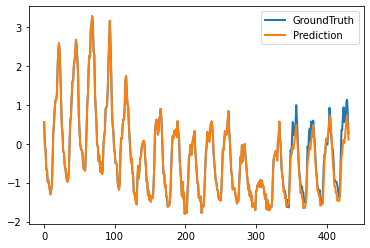

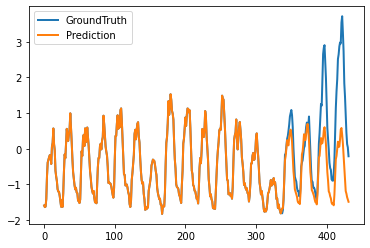

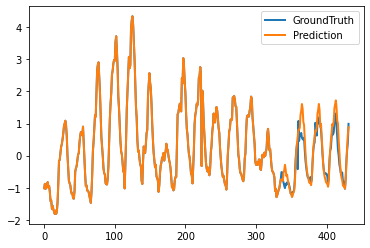

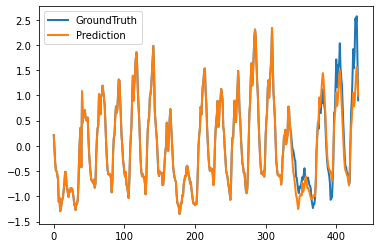

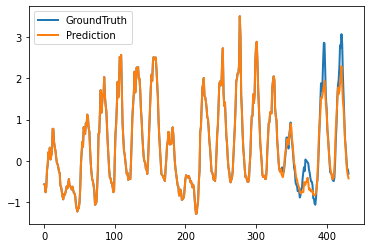

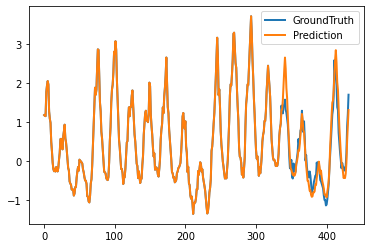

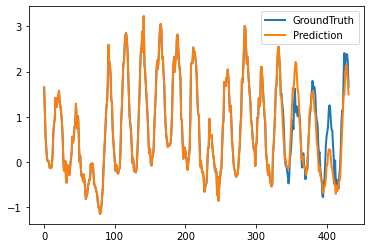

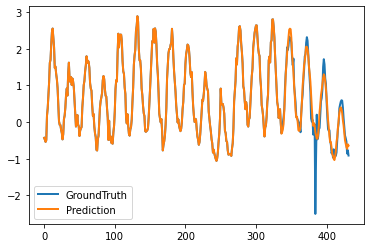

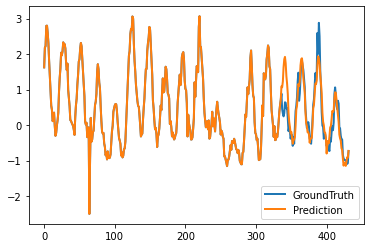

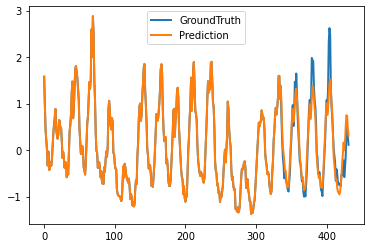

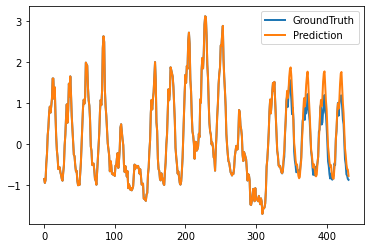

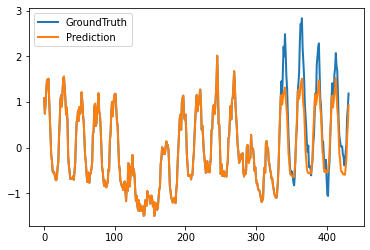

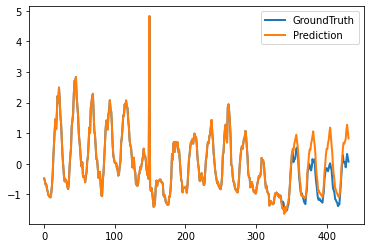

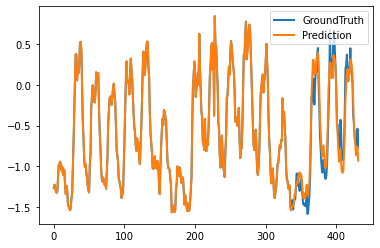

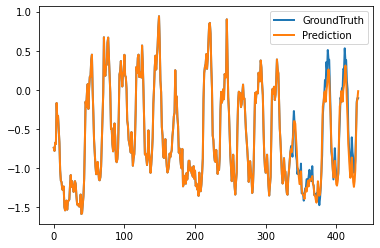

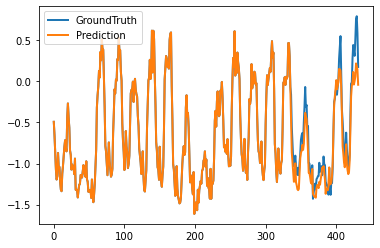

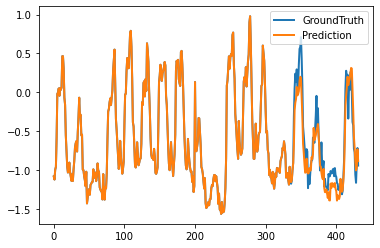

In [23]:
model.load_state_dict(torch.load("./checkpoints/checkpoint.pth"))

folder_path = r"./test_results/"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

preds = []
trues = []

model.eval()
with torch.no_grad():
    for batch_idx, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        outputs = model(batch_x)
        pred = outputs.detach().cpu().numpy()
        true = batch_y.detach().cpu().numpy()
        
        preds.append(pred)
        trues.append(true)

        if batch_idx % 20 == 0:
            input = batch_x.detach().cpu().numpy()
            gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
            pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
            visualize(gt, pd, os.path.join(folder_path, str(batch_idx) + '.pdf'))

preds = np.array(preds)
trues = np.array(trues)

mse = MSE(preds, trues)
mae = MAE(preds, trues)
print(f'MSE:{mse}, MAE:{mae}')

metrics = np.array([mae, mse])

np.save(folder_path + 'pred.npy', preds)
np.save(folder_path + 'true.npy', trues)
np.save(folder_path + 'metric.npy', metrics)